IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Statistics for net_income:
count    500000.000000
mean       2229.259633
std        1327.801058
min        -497.630000
25%        1102.280000
50%        2231.220000
75%        3356.692500
max        4946.780000
Name: net_income, dtype: float64


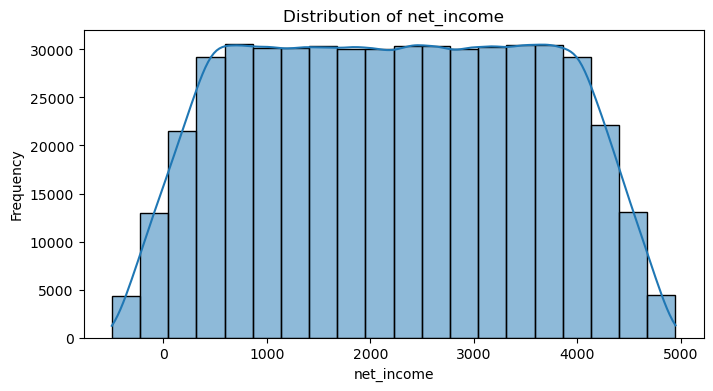

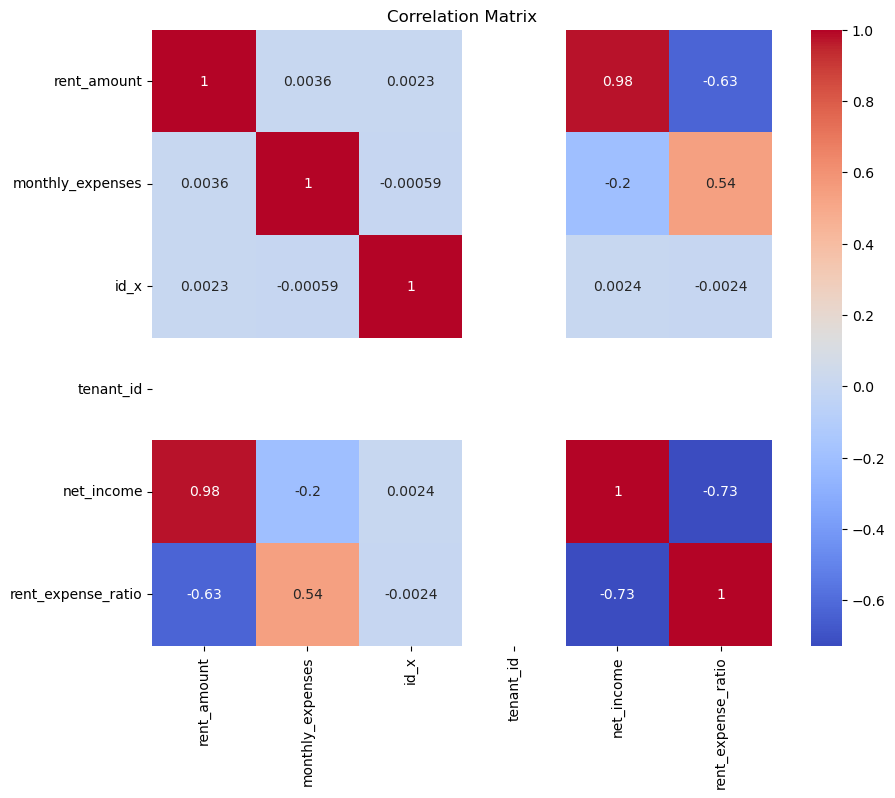

Exported properties_data to properties_data.csv
Exported tenants_data to tenants_data.csv
Exported merged_data to merged_data.csv
Script completed successfully.


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define Base URL for API
BASE_URL = "http://127.0.0.1:8000/api"

# 1. Utility Functions
def fetch_data(endpoint: str):
    """
    Fetches data from the given API endpoint and returns it as a DataFrame.
    """
    try:
        response = requests.get(f"{BASE_URL}/{endpoint}")
        response.raise_for_status()
        data = response.json()
        print(f"Fetched data from {endpoint}: {data}") 
        records = [
            {**item['fields'], 'id': item['pk']} for item in data[endpoint]
        ]
        return pd.DataFrame(records)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from API: {e}")
        return pd.DataFrame()
    except KeyError as e:
        print(f"Key error: {e} - Check the API response structure.")
        return pd.DataFrame()

def clean_data(df: pd.DataFrame):
    """
    Fills or drops missing values in the DataFrame.
    """
    # Fill numerical NaNs with 0 and string NaNs with 'Unknown'
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].fillna('Unknown')
        else:
            df[column] = df[column].fillna(0)
    return df

def assign_random_ids(df: pd.DataFrame, column: str, source_ids: list):
    """
    Assigns random IDs to a column in a DataFrame where the column has null values.
    """
    null_count = df[column].isnull().sum()
    if null_count > 0:
        random_ids = np.random.choice(source_ids, size=null_count, replace=True)
        df.loc[df[column].isnull(), column] = random_ids
    return df

def export_dataframes(dataframes: dict):
    """
    Exports a dictionary of DataFrames to CSV files.
    """
    for name, df in dataframes.items():
        filename = f"{name}.csv"
        df.to_csv(filename, index=False)
        print(f"Exported {name} to {filename}")

# 2. Fetch Data
properties_df = fetch_data("properties")
tenants_df = fetch_data("tenants")

# 3. Preprocess and Clean Data
# Handle empty or missing data
if properties_df.empty:
    print("Error: Properties DataFrame is empty. Check the API or database.")
    properties_df = pd.DataFrame(columns=["id", "property_name", "address", "owner", "rent_amount", "monthly_expenses", "status", "tenant_id"])

if tenants_df.empty:
    print("Warning: Tenants DataFrame is empty. Assigning placeholder values.")
    tenants_df = pd.DataFrame(columns=["id", "name", "email", "phone_number"])

# Ensure necessary columns exist
if "tenant_id" not in properties_df.columns:
    properties_df["tenant_id"] = np.nan

# Assign random tenant IDs to properties
if not tenants_df.empty and "id" in tenants_df.columns:
    properties_df = assign_random_ids(properties_df, "tenant_id", tenants_df["id"].tolist())
    properties_df["tenant_id"] = properties_df["tenant_id"].astype(int)
else:
    print("Warning: No valid tenant IDs to assign to properties.")

# Clean data
properties_df = clean_data(properties_df)
tenants_df = clean_data(tenants_df)


merged_df = pd.merge(properties_df, tenants_df, left_on="tenant_id", right_on="id", how="left")

# Convert rent_amount and monthly_expenses to numeric (coerce errors to NaN)
merged_df["rent_amount"] = pd.to_numeric(merged_df["rent_amount"], errors='coerce')
merged_df["monthly_expenses"] = pd.to_numeric(merged_df["monthly_expenses"], errors='coerce')

# Compute some derived metrics (e.g., rent-expense ratio)
merged_df["net_income"] = merged_df["rent_amount"] - merged_df["monthly_expenses"]
merged_df["rent_expense_ratio"] = merged_df["monthly_expenses"] / (merged_df["rent_amount"] + 1e-9)

# Visualize statistics
def compute_and_plot_statistics(df: pd.DataFrame, column: str):
    """
    Computes statistics for a specific column and plots its histogram and correlation matrix.
    """
    print(f"Statistics for {column}:")
    print(df[column].describe())
    
    # Histogram
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], bins=20, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()
    
    numerical_cols = df.select_dtypes(include=[np.number])
    correlation_matrix = numerical_cols.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

compute_and_plot_statistics(merged_df, "net_income")

# Export dataframes to CSV
export_dataframes({
    "properties_data": properties_df,
    "tenants_data": tenants_df,
    "merged_data": merged_df
})

print("Script completed successfully.")
